<i>Copyright (c) Microsoft Corporation. All rights reserved.</i>

<i>Licensed under the MIT License.</i>

# Training an Image Classification Model

In this notebook, we give an introduction to training an image classification model using [fast.ai](https://www.fast.ai/). Using a small dataset of four different beverage packages, we demonstrate how to train and evaluate a CNN image classification model. We also cover one of the most common ways to store data on a file system for this type of problem.

## Initialization

In [1]:
# Ensure edits to libraries are loaded and plotting is shown in the notebook.
%reload_ext autoreload
%autoreload 2
%matplotlib inline

Import all the functions we need.

In [2]:
import sys
sys.path.append("../../")

import numpy as np
from pathlib import Path
# import scrapbook as sb

# fastai and torch
import fastai
from fastai.vision.all import *
from fastai.metrics import accuracy
# from fastai.vision import (
#     models, ImageList, imagenet_stats, partial, cnn_learner, ClassificationInterpretation, to_np,
# )

# local modules
# from utils_cv.classification.model import TrainMetricsRecorder
from utils_cv.classification.plot import plot_pr_roc_curves
# from utils_cv.classification.widget import ResultsWidget
from utils_cv.classification.data import Urls
from utils_cv.common.data import unzip_url
from utils_cv.common.gpu import db_num_workers, which_processor

print(f"Fast.ai version = {fastai.__version__}")
which_processor()

Fast.ai version = 2.7.10
Torch is using GPU: NVIDIA GeForce GTX 1080


This shows your machine's GPUs (if has any) and the computing device `fastai/torch` is using. We suggest using an  [Azure DSVM](https://azure.microsoft.com/en-us/services/virtual-machines/data-science-virtual-machines/) Standard NC6 as a GPU compute resource.

Next, set some model runtime parameters. We use the `unzip_url` helper function to download and unzip the data used in this example notebook.

In [3]:
DATA_PATH     = unzip_url(Urls.fridge_objects_path, exist_ok=True)
EPOCHS        = 10
LEARNING_RATE = 1e-4
IM_SIZE       = 300

BATCH_SIZE    = 16
ARCHITECTURE  = models.resnet18

---

# Prepare Image Classification Dataset

In this notebook, we use a toy dataset called *Fridge Objects*, which consists of 134 images of 4 classes of beverage container `{can, carton, milk bottle, water bottle}` photos taken on different backgrounds. The helper function downloads and unzips data set to the `ComputerVision/data` directory.

Set that directory in the `path` variable for ease of use throughout the notebook.

In [4]:
path = Path(DATA_PATH)
path.ls()

(#4) [Path('/home/kejia/01_work/computervision-recipes/data/fridgeObjects/can'),Path('/home/kejia/01_work/computervision-recipes/data/fridgeObjects/milk_bottle'),Path('/home/kejia/01_work/computervision-recipes/data/fridgeObjects/carton'),Path('/home/kejia/01_work/computervision-recipes/data/fridgeObjects/water_bottle')]

You'll notice that we have four different folders inside:
- `/water_bottle`
- `/milk_bottle`
- `/carton`
- `/can`

This is most common data format for multiclass image classification. Each folder title corresponds to the image label for the images contained inside:

```
/images
+-- can (class 1)
|   +-- image1.jpg
|   +-- image2.jpg
|   +-- ...
+-- carton (class 2)
|   +-- image31.jpg
|   +-- image32.jpg
|   +-- ...
+-- ...
```

We have already set the data to this format structure. 

# Load Images

In fast.ai, an `ImageDataBunch` can easily use multiple images (mini-batches) during training time. We create the `ImageDataBunch` by using [data_block apis](https://docs.fast.ai/data_block.html).

For training and validation, we randomly split the data in an `8:2` ratio, holding 80% of the data for training and 20% for validation. One can also created dedicated train-test splits e.g. by placing the image structure shown above into parent-folders "train" and "valid" and then using [.split_by_folder()](https://docs.fast.ai/data_block.html#ItemList.split_by_folder) instead of .split_by_rand_pct() below.


In [5]:
dblock = DataBlock(
	blocks = (ImageBlock, CategoryBlock),
	get_items = get_image_files,
	get_y = parent_label,
	splitter = RandomSplitter(valid_pct=0.2, seed=10),
	item_tfms = Resize(IM_SIZE),
	# batch_tfms = [*aug_transforms(), Normalize.from_stats(*imagenet_stats)]
	batch_tfms = [Normalize.from_stats(*imagenet_stats)]
)

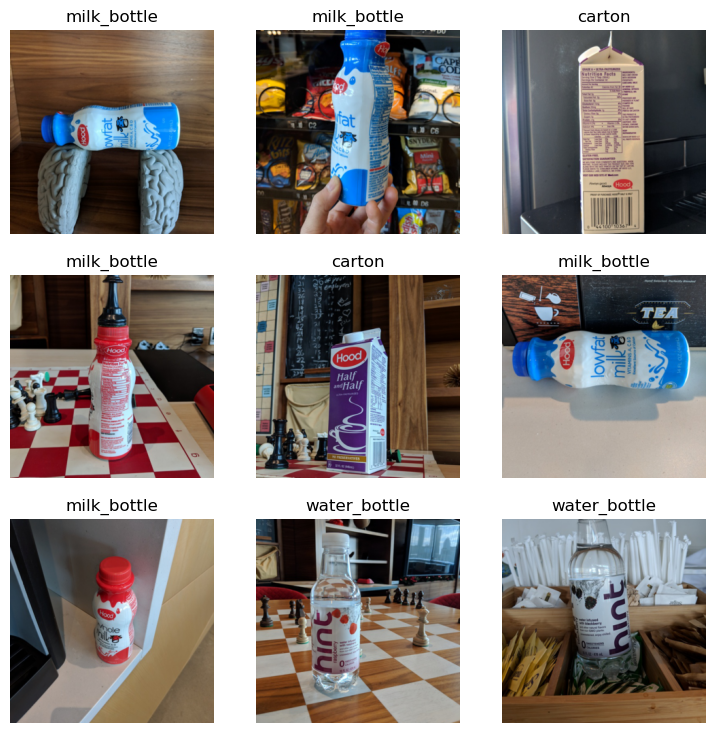

In [6]:
# dls = dblock.dataloaders(path, bs=BATCH_SIZE, device='cuda')
dls = dblock.dataloaders(path, bs=BATCH_SIZE)
dls.show_batch()

We examine some sample data using the `databunch` we created.

Show all available classes:

In [7]:
print(f'number of classes: {dls.c}')
print(dls.vocab)

number of classes: 4
['can', 'carton', 'milk_bottle', 'water_bottle']


Show the number of images in the training and validation set.

In a standard analysis, we would split the data into a train/validate/test data sets. For this example, we do not use a test set but this could be added using the [add_test](https://docs.fast.ai/data_block.html#LabelLists.add_test) method. Note that in the fast.ai framework, test sets do not include labels as this should be the unknown data to be predicted. The validation data set is a test set that includes labels that can be used to measure the model performance on new observations not used to train the model.

In [8]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

/home/kejia/miniconda3/envs/cv/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/home/kejia/miniconda3/envs/cv/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,1.733476,0.953154,0.307692,00:03


epoch,train_loss,valid_loss,error_rate,time
0,0.761838,0.654700,0.153846,00:01
1,0.554024,0.483163,0.115385,00:01
2,0.407359,0.386416,0.076923,00:01
3,0.300544,0.363592,0.076923,00:01


In [13]:
learn.predict(PILImage.create(path/"milk_bottle/65.jpg"))

('milk_bottle',
 TensorBase(2),
 TensorBase([1.7173e-06, 4.0990e-06, 9.9999e-01, 1.4073e-06]))

# Train a Model

For this image classifier, we use a **ResNet18** convolutional neural network (CNN) architecture. You can find more details about ResNet from [here](https://arxiv.org/abs/1512.03385).

When training CNN, there are almost an infinite number of ways to construct the model architecture. We need to determine how many and what type of layers to include and how many nodes make up each layer. Other hyperparameters that control the training of those layers are also important and add to the overall complexity of neural net methods. With fast.ai, we use the `create_cnn` function to specify the model architecture and performance metric. We will use a transfer learning approach to reuse the CNN architecture and initialize the model parameters used to train on [ImageNet](http://www.image-net.org/).

In this work, we use a custom callback `TrainMetricsRecorder` to track the model accuracy on the training set as we tune the model. This is for instruction only, as the standard approach in `fast.ai` [recorder class](https://docs.fast.ai/basic_train.html#Recorder) only supports tracking model accuracy on the validation set.

In [8]:
learn = Learner(
	dls,
	# models.resnet18(weights=ResNet18_Weights.DEFAULT),
	# ARCHITECTURE(weights=ResNet18_Weights.DEFAULT),
	ARCHITECTURE(),
	metrics=accuracy
)

Use the `unfreeze` method to allow us to retrain all the CNN layers with the <i>Fridge Objects</i> data set.

In [17]:
learn.unfreeze()

The `fit` function trains the CNN using the parameters specified above.

In [20]:
learn.fit(EPOCHS, LEARNING_RATE)

epoch,train_loss,valid_loss,accuracy,time
0,6.393246,6.673699,0.230769,00:01
1,5.691846,5.883766,0.346154,00:01
2,5.066246,4.798261,0.384615,00:01
3,4.455231,3.814924,0.346154,00:01
4,3.905483,3.266292,0.384615,00:01
5,3.407079,3.076785,0.461538,00:01
6,2.980103,2.734178,0.384615,00:01
7,2.606363,2.440787,0.461538,00:01
8,2.281170,2.350051,0.423077,00:01
9,2.012674,1.994427,0.461538,00:01


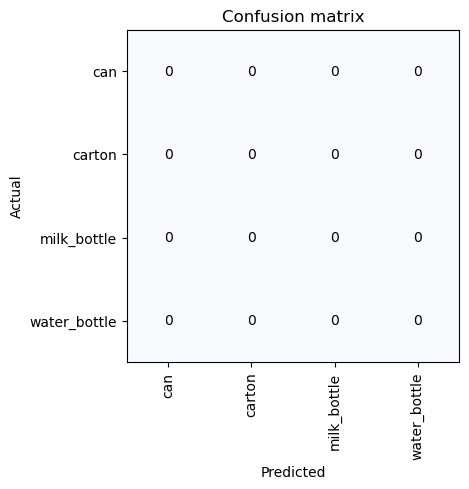

In [9]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [ ]:
interp.plot_top_losses(9, nrows=3)

In [ ]:
learn.

In [ ]:
k = 9
figsize = (12, 12)
tl_val,tl_idx = interp.top_losses(k, largest=True)
classes = interp.vocab
cols = math.ceil(math.sqrt(k))
rows = math.ceil(k/cols)
fig,axes = plt.subplots(rows, cols, figsize=figsize)

In [ ]:
interp.vocab

In [ ]:
# You can plot loss by using the default callback Recorder.
learn.recorder.plot_losses()

# Validate the model

To validate the model, calculate the model accuracy using the validation set.

In [ ]:
_, validation_accuracy = learn.validate(learn.data.valid_dl, metrics=[accuracy])
print(f'Accuracy on validation set: {100*float(validation_accuracy):3.2f}')

The `ClassificationInterpretation` module is used to analyze the model classification results.

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
# Get prediction scores. We convert tensors to numpy array to plot them later.
pred_scores = to_np(interp.preds)

To see these details use the widget helper class `ResultsWidget`. The widget shows test images along with the ground truth label and model prediction score. With this tool, it's possible to see how the model predicts each image and debug the model if needed. Note that Jupyter widgets are quite unstable - if the widget below does not show then see the "Troubleshooting" section in this [FAQ](./FAQ.md) for possible fixes. 

<img src="https://cvbp-secondary.z19.web.core.windows.net/images/ic_widget.png" width="600"/>
<center><i>Image Classification Result Widget</i></center>

In [ ]:
w_results = ResultsWidget(
    dataset=learn.data.valid_ds,
    y_score=pred_scores,
    y_label=[data.classes[x] for x in np.argmax(pred_scores, axis=1)],
)
display(w_results.show())

Aside from accuracy, precision and recall are other metrics that are also important in classification settings. These are linked metrics that quantify how well the model classifies an image against a known label, and where it fails. Since they are linked, there is a trade-off between optimizing for precision and optimizing for recall. They can be plotted against each other to graphically show how they are linked. 

In multiclass settings, we plot precision-recall and [ROC](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) curves for each class. In this example, the dataset is not complex and the accuracy is close to 100%. In more difficult settings, these figures will be more interesting.

In [ ]:
# True labels of the validation set. We convert to numpy array for plotting.
true_labels = to_np(interp.y_true)
plot_pr_roc_curves(true_labels, pred_scores, data.classes)

A confusion matrix details the number of images on which the model succeeded or failed. For each class, the matrix lists correct classifications along the diagonal, and incorrect ones off-diagonal. This allows a detailed look on how the model confused the prediction of some classes.

In [ ]:
interp.plot_confusion_matrix()

When evaluating our results, we want to see where the model makes mistakes and if we can help it improve. 

In [ ]:
interp.plot_top_losses(9, figsize=(15,11), heatmap=True)

In [ ]:
# Preserve some of the notebook outputs
training_losses = [x.numpy().ravel()[0] for x in learn.recorder.losses]
training_accuracies = [x[0].numpy().ravel()[0] for x in learn.recorder.metrics]
sb.glue("training_losses", training_losses)
sb.glue("training_accuracies", training_accuracies)
sb.glue("validation_accuracy", 100 * float(validation_accuracy))

# Conclusion

Using the concepts introduced in this notebook, you can bring your own dataset and train an image classifier to detect objects of interest for your specific setting. 